# RAG vs Agentic RAG <br>

### Classical RAG
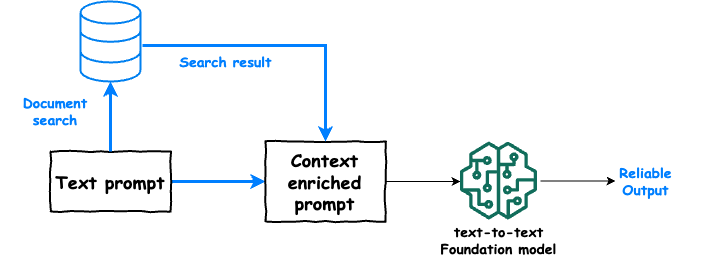



### Agentic RAG
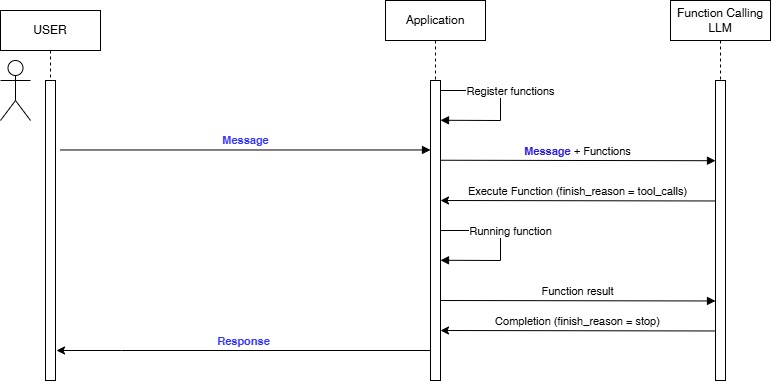

# Librerias


In [24]:
import json
import numpy as np
import os
from dotenv import load_dotenv
from openai import AzureOpenAI

# Carga de variables de .env

In [25]:
load_dotenv(override=True)

az_openai_endpoint = os.getenv("AZURE_OPENAI_ENDPOINT_URL")
az_openai_deployment_name = os.getenv("AZURE_OPENAI_DEPLOYMENT_NAME")
az_openai_api_key = os.getenv("AZURE_OPENAI_API_KEY")
az_openai_embeddings_deployment_name = os.getenv("AZURE_OPENAI_EMBEDDINGS_DEPLOYMENT_NAME")

# Crea el cliente Azure OpenAI

In [26]:
# Initialize the Azure OpenAI client
az_openai_client = AzureOpenAI(
    azure_endpoint=az_openai_endpoint,
    api_key=az_openai_api_key,
    api_version="2024-05-01-preview",
)

# Initializa mensajes

In [27]:
messages = []

# Message storage
def store_message_in_list(message_list, message_role, **kwargs):
    # Create the base message with the required role
    message = {"role": message_role}
    
    # Dynamically add additional fields from kwargs
    message.update(kwargs)
    # Append the message to the list
    message_list.append(message)


SYSTEM_MESSAGE = "Eres un asistente que ayuda"

store_message_in_list(messages, "system", content=SYSTEM_MESSAGE)
messages

[{'role': 'system', 'content': 'Eres un asistente que ayuda'}]

# Añadimos Tools - Busqueda en indice

### Funciones de ayuda

In [28]:
def calculate_embeddings(text, client=az_openai_client):
    embeddings_response = client.embeddings.create(input=text,
                model=az_openai_embeddings_deployment_name 
            )

    return embeddings_response.data[0].embedding

# Test with sample embedding

def cosine_similarity(vec1, vec2):
    """
    Calculate the cosine similarity between two vectors.

    Args:
        vec1 (np.array): First vector.
        vec2 (np.array): Second vector.

    Returns:
        float: Cosine similarity score.
    """
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return float(dot_product / (norm_vec1 * norm_vec2))

def find_most_similars(input_text, comparison_data, desired_doc_count=1):
    """
    Find the most similar text to an input.

    Args:
        input_text (str): Text to find similarities for.
        comparison_data (list): List of dictionaries with 'text' and 'embeddings' fields.
        desired_doc_count (int): Number of most similar documents to return.
    Returns:
        list: List of tuples containing texts and their similarity scores, sorted by similarity.
    """
    # Calculate the embeddings for the input text
    input_text_embedding = calculate_embeddings(input_text)

    # Calculate the similarity between the input text and each text in the comparison data
    similarities = []
    for entry in comparison_data:
        similarity = cosine_similarity(input_text_embedding, np.array(entry["embeddings"]))
        similarities.append((entry["text"], similarity))

    # Sort by similarity (highest first)
    sorted_documents = sorted(similarities, key=lambda x: x[1], reverse=True)

    return sorted_documents[:desired_doc_count]

### Tool de busqueda

In [29]:
embeddings_file = '../basic_rag/text_and_embeddings.json'
embeddings_list = json.load(open(embeddings_file, 'r'))

embeddings_list = [
    {
        "text": entry["text"],
        "embeddings": np.array(entry["embeddings"])
    }
    for entry in embeddings_list
]

def search_for_nutrition_info(input_text, comparison_data=embeddings_list, desired_doc_count=1):
    """
    Search for nutrition information based on an input text.

    Args:
        input_text (str): Text to search for.
        comparison_data (list): List of dictionaries with 'text' and 'embeddings' fields.
        desired_doc_count (int): Number of most similar documents to return.
    Returns:
        list: List of tuples containing text
    """
    # Find the most similar text to the input text
    most_similars = find_most_similars(input_text, comparison_data, desired_doc_count)

    most_similar_text = " ".join([entry[0] for entry in most_similars])

    return most_similar_text


## Probamos la tool

In [30]:
print(search_for_nutrition_info(input_text="How many calories are in an apple?"))
print(search_for_nutrition_info(input_text="Cuantas calorias en una manzana?"))

z. grilled chicken breast  150  ½ c. steamed asparagus  20  750  |  MyPlate Planner with 1 tsp. olive oil,  40     with 1 tsp. sesame seeds  18  ½ c. cooked wild rice  83     with ½ c. chopped kale  18  1 whole-wheat dinner roll  4     with 1 tsp. almond butter  33  691  (Total calories from all meals and  snacks = 1,814)  Discretionary calorie allowance: 186  (Total calories from all meals and snacks = 1,814)  Discretionary calorie allowance: 186  Healthy Eating Index  To assess whether the American diet is conforming to the Dietary  Guidelines, the Center for Nutrition Policy and Promotion (CNPP),  a division of the USDA, uses a standardized tool called the Healthy  Eating Index (HEI)2.  The first HEI was developed in 1995 and revised in 2006. This  tool is a simple scoring system of dietary components. The data for  scoring diets is taken from national surveys of particular population  subgroups, such as children from low-income families or Americans  over the age of sixty-five. Die

## Registro de tools para llamada a Azure OpenAI

In [31]:
tool_map = {
    "search_for_nutrition_info": search_for_nutrition_info
}

tools = [
    {
        "type": "function",
        "function": {
            "name": "search_for_nutrition_info",
            "description": "Search for nutrition information based on an input text.",
            "parameters": {
                "type": "object",
                "properties": {
                    "input_text": {
                        "type": "string",
                        "description": "The content to search for"
                    },
                },
                "required": ["input_text"],
            },
        }
    }
]

## Llamada a API con tools

In [32]:
def call_azure_openai_with_tools(az_openai_client, az_openai_deployment_name, messages, tools=tools, tool_choice="auto"):
    # Build the parameters dynamically
    params = {
        "model": az_openai_deployment_name,
        "messages": messages,
        "tools": tools,
        "tool_choice": tool_choice
    }

    # Call the Azure OpenAI API
    response = az_openai_client.chat.completions.create(**params)
    return response.choices[0]

def send_user_input_to_az_openai_with_tools(
    user_input,
    az_openai_client = az_openai_client,
    az_openai_deployment_name = az_openai_deployment_name,
    messages = messages,
    tools = tools,
    tool_choice = "auto"
):
    # Store user message
    store_message_in_list(messages, "user", content=user_input)
    # Query AzOpenAI
    az_openai_response = call_azure_openai_with_tools(az_openai_client, az_openai_deployment_name, messages,  tools, tool_choice)

    az_openai_response
    
    return az_openai_response

In [33]:
user_question = "Cuantas calorias tiene una manzana?"
model_response = send_user_input_to_az_openai_with_tools(user_question)

model_response

Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_BRAqYhX22fnRwYlmjH4rwkOa', function=Function(arguments='{"input_text":"manzana"}', name='search_for_nutrition_info'), type='function')]), content_filter_results={})

## La respuesta del modelo indica que hay que ejecutar una tool
finish_reason no es stop. Nos indica que hay una tool_call pendiente

In [34]:
tool_call = model_response.message.tool_calls[0].function

tool_call

Function(arguments='{"input_text":"manzana"}', name='search_for_nutrition_info')

## Almacenamos la respuesta en lista de mensajes

In [35]:
store_message_in_list(
    messages,
    "assistant",
    function_call=tool_call
)

## Obtenemos parametros y nombre de la funcion

In [36]:
function_name = tool_call.name
function_args = json.loads(tool_call.arguments)

## Llamamos a la funcion

In [37]:
function_call_result = tool_map[function_name](**function_args)
function_call_result

'easurer.  About the Contributors  |  xxxi Cheryl Gibby  Cheryl Gibby was born and raised in Hawai‘i and is a wife and  mother of three. She received her BA, MS in Nutritional Sciences,  and PhD in Nutrition from the University of Hawai‘i at Mānoa. She  has served as an instructor for the introductory Nutrition course  at the University of Hawai‘i at Mānoa, and her research interests  include infant and child health, dental and bone health, mobile  health  interventions,  school  nutrition  policies,  and  online  education.  xxxii  |  About the Contributors Skylar Hara  Skylar Hara is aonline  education.  xxxii  |  About the Contributors Skylar Hara  Skylar Hara is an undergraduate student student in the Tropical  Agriculture and the Environment program at the University of  Hawai‘i at Mānoa. She has a growing love for plants and hopes to go  to graduate school to conduct research in the future.  About the Contributors  |  xxxiii Gemady Langfelder  Gemady Langfet the Contributors  |  

## Guardamos el resultado en la lista de mensajes

In [38]:
store_message_in_list(
    messages,
    "function",
    content=function_call_result,
    name=function_name
)

In [39]:
messages

[{'role': 'system', 'content': 'Eres un asistente que ayuda'},
 {'role': 'user', 'content': 'Cuantas calorias tiene una manzana?'},
 {'role': 'assistant',
  'function_call': Function(arguments='{"input_text":"manzana"}', name='search_for_nutrition_info')},
 {'role': 'function',
  'content': 'easurer.  About the Contributors  |  xxxi Cheryl Gibby  Cheryl Gibby was born and raised in Hawai‘i and is a wife and  mother of three. She received her BA, MS in Nutritional Sciences,  and PhD in Nutrition from the University of Hawai‘i at Mānoa. She  has served as an instructor for the introductory Nutrition course  at the University of Hawai‘i at Mānoa, and her research interests  include infant and child health, dental and bone health, mobile  health  interventions,  school  nutrition  policies,  and  online  education.  xxxii  |  About the Contributors Skylar Hara  Skylar Hara is aonline  education.  xxxii  |  About the Contributors Skylar Hara  Skylar Hara is an undergraduate student student 

## Llamamos al LLM con el resultado de la tool

In [40]:
response = call_azure_openai_with_tools(az_openai_client, az_openai_deployment_name, messages, tools)
response.message.content

'Una manzana mediana generalmente contiene alrededor de **95 calorías**. Esta cifra puede variar ligeramente según el tamaño y la variedad de la manzana. Las manzanas también son una buena fuente de fibra dietética y vitamina C.'

## Gracias al uso de tools, sabemos el resultado!